# Therkildsen et al. (2019) Data Processing and Analysis

## Setup

In [2]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [3]:
import re
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl

In [4]:
from cvtk.cvtk import TemporalFreqs, TiledTemporalFreqs
from cvtk.cov import stack_temporal_covariances
import cvtk.variant_files as vf
from cvtk.gintervals import GenomicIntervals
from cvtk.pca import FreqPCA
from cvtk.plots import rep_plot_pca, correction_diagnostic_plot
from cvtk.utils import integerize
from cvtk.utils import extract_empirical_nulls_diagonals, extract_temporal_cov_diagonals
from cvtk.cov import stack_replicate_covariances, stack_temporal_covs_by_group

In [5]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.figsize'] = (8.0, 4.0)
mpl.rcParams['figure.dpi'] = 200

# Data and Annotation Loading

In [31]:
rd = pd.read_csv('../data/therkildsen_et_al_2019/Menidia_SelectionExp_AFreqs_Depths.txt', delimiter='\t')

/home/vinceb/miniconda3/envs/basesci/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [32]:
rd.head()

,SNP,Contig,Pos,MajorAllele,MinorAllele,RefAllele,RGen0_MAF,RGen0_nInd,RGen0_Depth,D1Gen5_MAF,...,U1Gen5_nInd,U1Gen5_Depth,U2Gen5_MAF,U2Gen5_nInd,U2Gen5_Depth,MedakaChr,Var_type,Impact,GeneStart,GeneStop
0,Contig5248:100,Contig5248,100,C,T,C,0.029186,53.0,106.0,0.000002,...,42.0,72.0,0.081617,28.0,47.0,1,3_prime_UTR_variant,MODIFIER,164201.0,167143.0
1,Contig5248:1011,Contig5248,1011,T,A,T,0.270349,59.0,122.0,0.244544,...,26.0,54.0,0.378888,44.0,94.0,1,3_prime_UTR_variant,MODIFIER,164201.0,167143.0
2,Contig5248:1012,Contig5248,1012,A,T,A,0.558003,59.0,126.0,0.616961,...,43.0,94.0,0.304023,45.0,99.0,1,3_prime_UTR_variant,MODIFIER,164201.0,167143.0
3,Contig5248:1013,Contig5248,1013,A,T,A,0.000003,60.0,126.0,0.000001,...,43.0,96.0,0.000001,46.0,101.0,1,3_prime_UTR_variant,MODIFIER,164201.0,167143.0
4,Contig5248:1033,Contig5248,1033,T,C,T,0.021789,64.0,144.0,0.000001,...,46.0,106.0,0.000001,45.0,101.0,1,3_prime_UTR_variant,MODIFIER,164201.0,167143.0


Extract out the matrices. We duplicate the first generation for each replicate population, but it is shared so the shared sampling noise must be accounted for. We wish to build matrices with the following sample layout:

In [60]:
sample_layout = ['RGen0', 'D1Gen5', 'RGen0', 'D2Gen5', 'RGen0', 'R1Gen5', 'RGen0', 'R2Gen5', 'RGen0', 'U1Gen5', 'RGen0', 'U2Gen5']
sample_layout

['RGen0',
 'D1Gen5',
 'RGen0',
 'D2Gen5',
 'RGen0',
 'R1Gen5',
 'RGen0',
 'R2Gen5',
 'RGen0',
 'U1Gen5',
 'RGen0',
 'U2Gen5']

In [61]:
freqs = rd[[s + '_MAF' for s in sample_layout]].values
depths = rd[[s + '_Depth' for s in sample_layout]].values
diploids = rd[[s + '_nInd' for s in sample_layout]].values

In [62]:
gi = GenomicIntervals()
for row in rd.itertuples(index=False):
    seqid = row[1]
    gi.append(seqid, int(row[2]))
gi.infer_seqlens()

In [65]:
samples = [('D1', 0), ('D1', 5), ('D2', 0), ('D2', 5), ('R1', 0), ('R1', 5), ('R2', 0), ('R2', 5), ('U1', 0), ('U1', 5), ('U2', 0), ('U2', 5)]

In [48]:
tile_width = 1e5
tiles = GenomicIntervals.from_tiles(gi.seqlens, width=tile_width)

In [79]:
mean_diploids = np.nanmean(diploids, axis=0)
d = TiledTemporalFreqs(tiles, freqs=freqs.T, depths=depths.T, diploids=mean_diploids, gintervals=gi, samples=samples)

In [99]:
gw_covs = d.calc_covs(use_masked=True, standardize=False)

In [109]:
gw_covs

array([[        nan, -0.0003467 , -0.00034356, -0.00045898, -0.00057475,
        -0.00053709],
       [-0.0003467 ,         nan,  0.00014882, -0.00044735, -0.00063695,
        -0.0003658 ],
       [-0.00034356,  0.00014882,         nan,  0.00010272, -0.00016272,
         0.00039022],
       [-0.00045898, -0.00044735,  0.00010272,         nan, -0.00011343,
         0.00016864],
       [-0.00057475, -0.00063695, -0.00016272, -0.00011343,         nan,
         0.00051458],
       [-0.00053709, -0.0003658 ,  0.00039022,  0.00016864,  0.00051458,
                nan]])

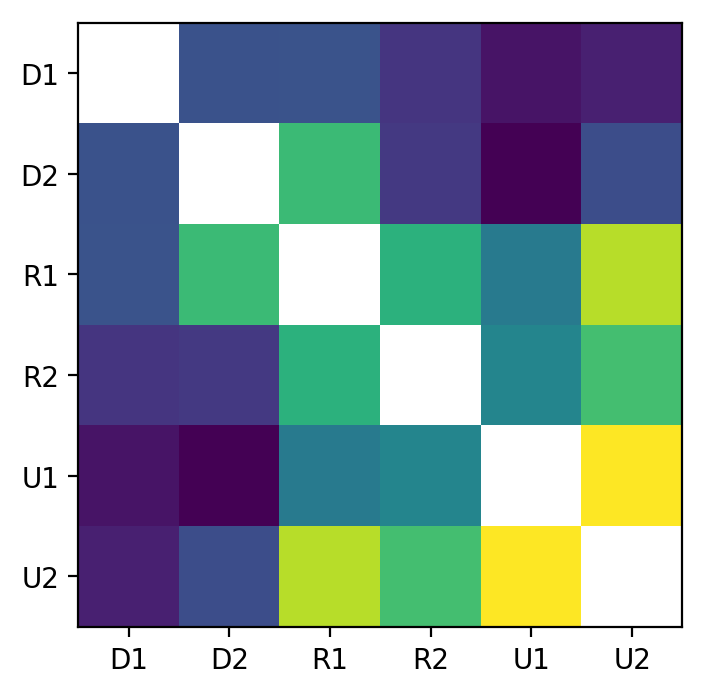

In [108]:
np.fill_diagonal(gw_covs, np.nan)
fig, ax = plt.subplots()
ax.imshow(gw_covs)
sample_names = ['', 'D1', 'D2', 'R1', 'R2', 'U1', 'U2']
ax.set_xticklabels(sample_names)
ax.set_yticklabels(sample_names)
plt.show()

In [87]:
diagnostics = d.correction_diagnostics()
_ = correction_diagnostic_plot(diagnostics)

ValueError: zero-size array to reduction operation maximum which has no identity